# Group 100 Project: Memory Allocation Simulation
 Our project simulates memory allocation using the First Fit algorithm. The simulation visualizes step-by-step using Matplotlib, with an interactive user interface using IPyWidgets

 Demonstration video can be watched here: https://youtu.be/VpMAYYD40QE

## Inputs

* **Process Number:** A slider for inputting the number of processes
* **Process Time:** A numerical input for setting the total time of each process
* **Process Size:** A numerical input for setting the total size of each process
* **Compaction Time:** Sets the time interval for when a compaction is executed
* **Coalescing Time:** Sets the time interval for when coalescing is executed
* **Run:** Starts the simulation
* **Reset:** Clears output and resets all input back to default

## Classes:

* **Process:** Has time and size
* **Node:** A doubly linked list node representing a single block of the memory
* **MemorySimulation:** Contains all logic for simulating memory allocation
* **MemorySimulationPage:** Represents a single snapshot of MemorySimulation during its runtime used for debugging and visualization purposes

## Instructions

1. **Set Memory Size:** Define the total available memory for the simulation.
2. **Adjust Number of Processes:** Use the slider to set the number of processes to simulate and input fields for each process will appear dynamically.
3. **Enter Process Details:** For each process specify the required memory size and its execution time.
4. **Set Compaction and Coalescing Times:** Configure compaction and coalescing times.
5. **Run Simulation:** Click the "Run Simulation" button to initiate  and visualize the memory allocation process.
6. **Clear Inputs:** Click the "Clear" button to reset all inputs to the default values.

## Group Members

* Conciso, Psalmwel Kyle M.
* Laudes, Jaden Louie

In [ ]:
#@title Main logic and classes (Node, Memory, Process, Processor)
from typing import List, Callable
from enum import Enum
import matplotlib.pyplot as plt
import time

class Process:
    def __init__(self, symbol, size, duration):
        self.symbol = symbol
        self.size = size
        self.remaining_time = duration

    def tick(self):
        self.remaining_time -= 1
        return self.remaining_time <= 0

    def is_finished(self):
        return self.remaining_time <= 0

# Doubly linked-list implementation of memory nodes
class Node:
    def __init__(self):
        self.data = {}
        self.next = None
        self.prev = None

    def __getitem__(self, key):
        return self.data[key]

    def __setitem__(self, key, value):
        self.data[key] = value

    def __iter__(self):
        current = self
        while current:
            next = current.next
            yield current
            current = next

    @staticmethod
    def next(a):
        current = a
        while current:
            yield current
            current = current.next

    @staticmethod
    def prev(a):
        current = a
        while current:
            yield current
            current = current.prev

    @staticmethod
    def cut(a):
        a_prev, a_next = a.prev, a.next
        a.prev = None
        a.next = None
        if a_prev:
            a_prev.next = a_next
        if a_next:
            a_next.prev = a_prev
        return a

    @staticmethod
    def head(a):
        current = a
        while current.prev is not None:
            current = current.prev
        return current

    @staticmethod
    def tail(a):
        current = a
        while current.next is not None:
            current = current.next
        return current

    @staticmethod
    def insert_before(a, b):
        a_prev, a_next, b_prev, b_next = a.prev, a.next, b.prev, b.next
        Node.cut(b)
        b.prev = a_prev
        b.next = a
        a.prev = b
        if a_prev:
            a_prev.next = b
        if b_next:
            b_next.prev = b

    @staticmethod
    def insert_after(a, b):
        Node.cut(b)
        b.prev = a
        b.next = a.next
        a.next = b
        if b.next:
            b.next.prev = b

class MemoryNode(Node):
    def __init__(self, size):
        super().__init__()
        self["size"] = size
        self["process"] = None

    def is_busy(self):
        return (self["process"]) and (not self["process"].is_finished())

class Memory:
    def __init__(self, size, show_visualization = False, event_callback: Callable[[MemoryNode,int,str,str],None]=None):
        self.size = size
        self.head = MemoryNode(size)
        self.show_visualization = show_visualization
        self.event_callback = event_callback

    def __str__(self):
        output = "Memory Visualization:\n"
        output += "---------------------\n"

        current = self.head
        total_size = self.size
        occupied_size = 0
        visited = set()

        while current and current not in visited:
            visited.add(current)

            size = current["size"]
            process = current["process"]

            if process:
                output += f"[P{process.symbol}: {size} (T={process.remaining_time})]"
                occupied_size += size
            else:
                output += f"[Free: {size}]"

            current = current.next

        if current:  # Check if cycle was detected
            output += "\n*** Cycle detected in memory structure! ***\n"
        output += "\n---------------------\n"
        output += f"Total Size: {total_size}, Occupied: {occupied_size}, Free: {total_size - occupied_size}\n"
        return output

    def refresh_head(self):
        self.head = Node.head(self.head)

    def coalesce(self):
        moves = 0
        subset_head = None
        tail = Node.tail(self.head)
        for node in self.head:
            if not node.is_busy():
                if not subset_head:
                    subset_head = node
                    subset_head["process"] = None
                else:
                    Node.cut(node)
                    subset_head["size"] += node["size"]
                    moves += 1
            else:
                subset_head = None
        self.refresh_head()
        if moves > 0:
            self.visualize(f"CH", f"Coalescing free adjacent blocks")
        return moves

    def compact(self):
        moves = 0
        anchor = None
        for node in self.head:
            if not node.is_busy():
                if not anchor:
                    anchor = node
            elif anchor:
                if anchor.prev:
                    for prev_node in Node.prev(anchor.prev):
                        if prev_node["process"].size <= node["process"].size:
                            Node.cut(node)
                            Node.insert_before(prev_node, node)
                            break
                else:
                    Node.cut(node)
                    Node.insert_before(anchor, node)
                moves += 1
                self.visualize(f"SC", f"Compacting blocks")

        self.refresh_head()
        return moves

    def allocate(self, process):
        if process.size > self.size:
            return None

        for node in self.head:
            if (not node.is_busy()) and (node["size"] >= process.size):
                if node["size"] > process.size:
                    Node.insert_after(node, MemoryNode(node["size"] - process.size))
                    node["size"] = process.size
                node["process"] = process
                return True
        self.refresh_head()
        return None

    def deallocate(self, process):
        for node in self.head:
            if node["process"] == process:
                node["process"] = None
                return

    def visualize(self, visualize_symbol, description):
        if self.event_callback:
            self.event_callback(self.head, self.size, visualize_symbol, description)

        if not self.show_visualization:
            return

        memory_blocks = []
        labels = []
        colors = []
        patterns = []
        max_size = self.size

        self.refresh_head()
        for current in self.head:
            size = current["size"]
            memory_blocks.append(size)
            process = current["process"]

            if process:
                label = f"{size}\nP{process.symbol}\nT={process.remaining_time}"
                labels.append(label)
                color_intensity = size / max_size
                color = plt.cm.YlOrRd(color_intensity)
                colors.append(color)
                if process.remaining_time == 0:
                    patterns.append("/")
                else:
                    patterns.append(None)
            else:
                labels.append(f"{size}\nFree")
                colors.append("gray")
                patterns.append(None)


        fig, ax = plt.subplots(figsize=(10, 2))
        bars = ax.barh([0], memory_blocks, left=np.cumsum([0] + memory_blocks[:-1]), color=colors, edgecolor='black')

        for bar, label, pattern in zip(bars, labels, patterns):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, label,
                    ha='center', va='center', color='black', fontweight='bold')
            if pattern:
                bar.set_hatch(pattern)

        ax.set_xlim(0, max_size)
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)

        ax.set_title(f"Memory Visualization: Step {visualize_symbol} - {description}")
        plt.show()

class ProcessorEvent:
    def __init__(self, head, time, symbol, description):
        self.head = head
        self.time = time
        self.symbol = symbol
        self.description = description

class Processor:
    def __init__(self, processes, memory_size, coalescing_time, compacting_time, event_listener: Callable[[ProcessorEvent], None]=None, show_plot=True):
        self.processes = processes
        self.memory = Memory(memory_size,
                             show_plot,
                             lambda head,time,sym,desc: event_listener(ProcessorEvent(head,time,sym,desc)))
        self.coalescing_time = coalescing_time
        self.compacting_time = compacting_time

    def run(self):
        current_time = 0
        finished_processes = {}
        active_processes = {}
        queue_processes = {i: v for i,v in enumerate(self.processes)}
        process_counter = 0

        def next_process():
            nonlocal process_counter
            for i in range(1, len(self.processes)):
                j = (process_counter+i)%len(self.processes)
                if j in active_processes:
                    process_counter = j
                    return j
            return None

        while active_processes or queue_processes:
            time.sleep(0)
            # print(f"Current Time: {current_time}")
            # print(f"Process Counter: {process_counter}")

            # 1. coalescing and compacting
            # print("1")
            # print(self.memory)
            coalesce_compact = False
            if current_time % self.compacting_time == 0:
                # print("a")
                moves = self.memory.compact()
                if moves > 0:
                    coalesce_compact = True
                    current_time += 1
            if current_time % self.coalescing_time == 0:
                # print("b")
                moves = self.memory.coalesce()
                if moves > 0:
                    coalesce_compact = True
                    current_time += 1
            if coalesce_compact:
                # print("1.2")
                continue

            # 2. iterate all unallocated processes
            # print("2")
            allocated = None
            for i, q_process in queue_processes.items():
                if self.memory.allocate(q_process):
                    # print("c")
                    active_processes[i] = q_process
                    del queue_processes[i]
                    allocated = i
                    break

            # 3. round robin
            # print("3")
            current_process = None
            # next_process()
            if allocated:
                current_process = active_processes[allocated]
            elif len(active_processes) > 0:
                current_process = active_processes.get(process_counter)
            if current_process:
                current_process_id = allocated or process_counter
                # print("d")
                current_process.tick()
                # print(current_process.remaining_time)
                current_time += 1
                if allocated is None:
                    self.memory.visualize(f"J{current_process.symbol}", f"Running Process P{current_process.symbol} (Size: {current_process.size})")
                else:
                    self.memory.visualize(f"A{q_process.symbol}", f"Allocated Process P{q_process.symbol} (Size: {q_process.size})")
                if current_process.is_finished():
                    # print("e")
                    finished_processes[current_process_id] = current_process
                    if active_processes.get(current_process_id):
                        del active_processes[current_process_id]
                    self.memory.deallocate(current_process)

            if allocated is None:
                next_process()
                if current_process is None:
                    current_time += 1
                    self.memory.visualize(f"N", f"Waiting for Resources")

In [ ]:
#@title User Interface
import ipywidgets as widgets
import random
import numpy as np
from IPython.display import display, HTML


default_processes = [
    {"size": 500, "time": 3},
    {"size": 250, "time": 4},
    {"size": 200, "time": 5},
    {"size": 350, "time": 3},
    {"size": 60, "time": 5},
    {"size": 300, "time": 3},
    {"size": 400, "time": 2}
]

memory_size_input = widgets.IntText(value=1000, description="Memory Size:", layout=widgets.Layout(width='320px'))
num_processes_slider = widgets.IntSlider(value=7, min=1, max=50, step=1, description="Processes:", layout=widgets.Layout(width='320px'))
compaction_time_input = widgets.IntText(value=20, description="Compaction Time:", layout=widgets.Layout(width='320px'))
coalescing_time_input = widgets.IntText(value=1, description="Coalescing Time:", layout=widgets.Layout(width='320px'))
show_plot_checkbox = widgets.Checkbox(value=False, description="Show Visualization", layout=widgets.Layout(width='320px'))

for widget in [memory_size_input, num_processes_slider, compaction_time_input, coalescing_time_input, show_plot_checkbox]:
    widget.style.description_width = '160px'

process_inputs_box = widgets.VBox()

def update_process_inputs(change=None):
    process_inputs = []
    for i in range(num_processes_slider.value):
        size_default = default_processes[i]["size"] if i < len(default_processes) else 100
        time_default = default_processes[i]["time"] if i < len(default_processes) else 5

        size_input = widgets.IntText(value=size_default, description=f"Process {i+1} Size:", layout=widgets.Layout(width='320px'))
        time_input = widgets.IntText(value=time_default, description=f"Process {i+1} Time:", layout=widgets.Layout(width='320px'))

        size_input.style.description_width = '160px'
        time_input.style.description_width = '160px'

        process_inputs.append(widgets.HBox([size_input, time_input]))
    process_inputs_box.children = process_inputs

num_processes_slider.observe(update_process_inputs, names='value')
update_process_inputs()

run_button = widgets.Button(description="Run Simulation", button_style='success', layout=widgets.Layout(width='150px'))
clear_button = widgets.Button(description="Clear", button_style='danger', layout=widgets.Layout(width='150px'))
randomize_button = widgets.Button(description="Randomize", button_style='info', layout=widgets.Layout(width='150px'))
output = widgets.Output()

def run_simulation(b):
    output.clear_output()
    with output:
        total_memory_size = memory_size_input.value
        compaction_time = compaction_time_input.value
        coalescing_time = coalescing_time_input.value
        show_plot = show_plot_checkbox.value

        process_list = []
        for process_box in process_inputs_box.children:
            size_input = process_box.children[0]
            time_input = process_box.children[1]
            process_list.append(Process(f"{len(process_list) + 1}", size_input.value, time_input.value))

        events = []
        def event_callback(event):
            events.append(event)

        processor = Processor(process_list, total_memory_size, coalescing_time, compaction_time, event_callback, show_plot=show_plot_checkbox.value)
        processor.run()

        display(HTML("<h3 style='color: #4CAF50; font-size: 18px;'>Simulation Results</h3>"))
        display(HTML(f"<p><strong>Total Execution Time:</strong> {len(events)}</p>"))
        process_flow = "".join([f"<span style='font-weight: bold; color: #2196F3;'>[{evt.symbol}]</span>, " for evt in events])
        display(HTML(f"<p><strong>Process Flow:</strong> {process_flow}</p>"))

def clear_inputs(b):
    memory_size_input.value = 1000
    num_processes_slider.value = 7
    compaction_time_input.value = 20
    coalescing_time_input.value = 1
    show_plot_checkbox.value = False
    update_process_inputs()
    output.clear_output()

def randomize_processes(b):
    max_memory_size = memory_size_input.value
    for i, process_box in enumerate(process_inputs_box.children):
        size_input = process_box.children[0]
        time_input = process_box.children[1]

        # randomize size between 1 and max_memory_size, and time between 1 and 10
        size_input.value = random.randint(1, max_memory_size)
        time_input.value = random.randint(1, 10)

run_button.on_click(run_simulation)
clear_button.on_click(clear_inputs)
randomize_button.on_click(randomize_processes)

input_panel = widgets.VBox([
    widgets.HTML("<h2 style='color: #4CAF50;'>Group 100 Memory Allocation Simulator</h2>"),
    widgets.HTML("<p style='font-size: 14px;'>Simulate memory allocation using First Fit and Round-Robin algorithm. Adjust parameters then run the simulation to view results.</p>"),
    memory_size_input, num_processes_slider, process_inputs_box,
    compaction_time_input, coalescing_time_input, show_plot_checkbox,
    widgets.HBox([run_button, clear_button, randomize_button], layout=widgets.Layout(margin='10px 0')),
    output
], layout=widgets.Layout(border='2px solid #e0e0e0', padding='20px', border_radius='10px', box_shadow='0 4px 8px rgba(0, 0, 0, 0.1)', width='100%'))

right_panel = widgets.VBox([
    widgets.HTML("<h3 style='color: #4CAF50;'>Instructions</h3>"),
    widgets.HTML("<ul style='font-size: 14px; line-height: 1.6;'><li>Set memory size and number of processes.</li>"
                 "<li>Adjust each process size and duration.</li>"
                 "<li>Set compaction and coalescing times.</li>"
                 "<li>Click 'Run Simulation' to start.</li>"
                 "<li>Click 'Clear' to reset the fields.</li></ul>"),
    widgets.HTML("<h3 style='color: #4CAF50;'>Team Members</h3>"),
    widgets.HTML("<ul style='font-size: 14px; line-height: 1.6;'><li>Kyle Conciso</li><li>Jaden Laudes</li></ul>"),
    widgets.HTML("<h3 style='color: #4CAF50;'>Notes</h3>"),
    widgets.HTML("<ul style='font-size: 14px; line-height: 1.6;'><li>This project is submitted as a requirement for ITS150L</li></ul>")
], layout=widgets.Layout(padding='20px', width='350px', border='2px solid #e0e0e0', border_radius='10px', box_shadow='0 4px 8px rgba(0, 0, 0, 0.1)'))

main_layout = widgets.HBox([input_panel, right_panel], layout=widgets.Layout(align_items='flex-start', justify_content='space-between'))

display(main_layout)


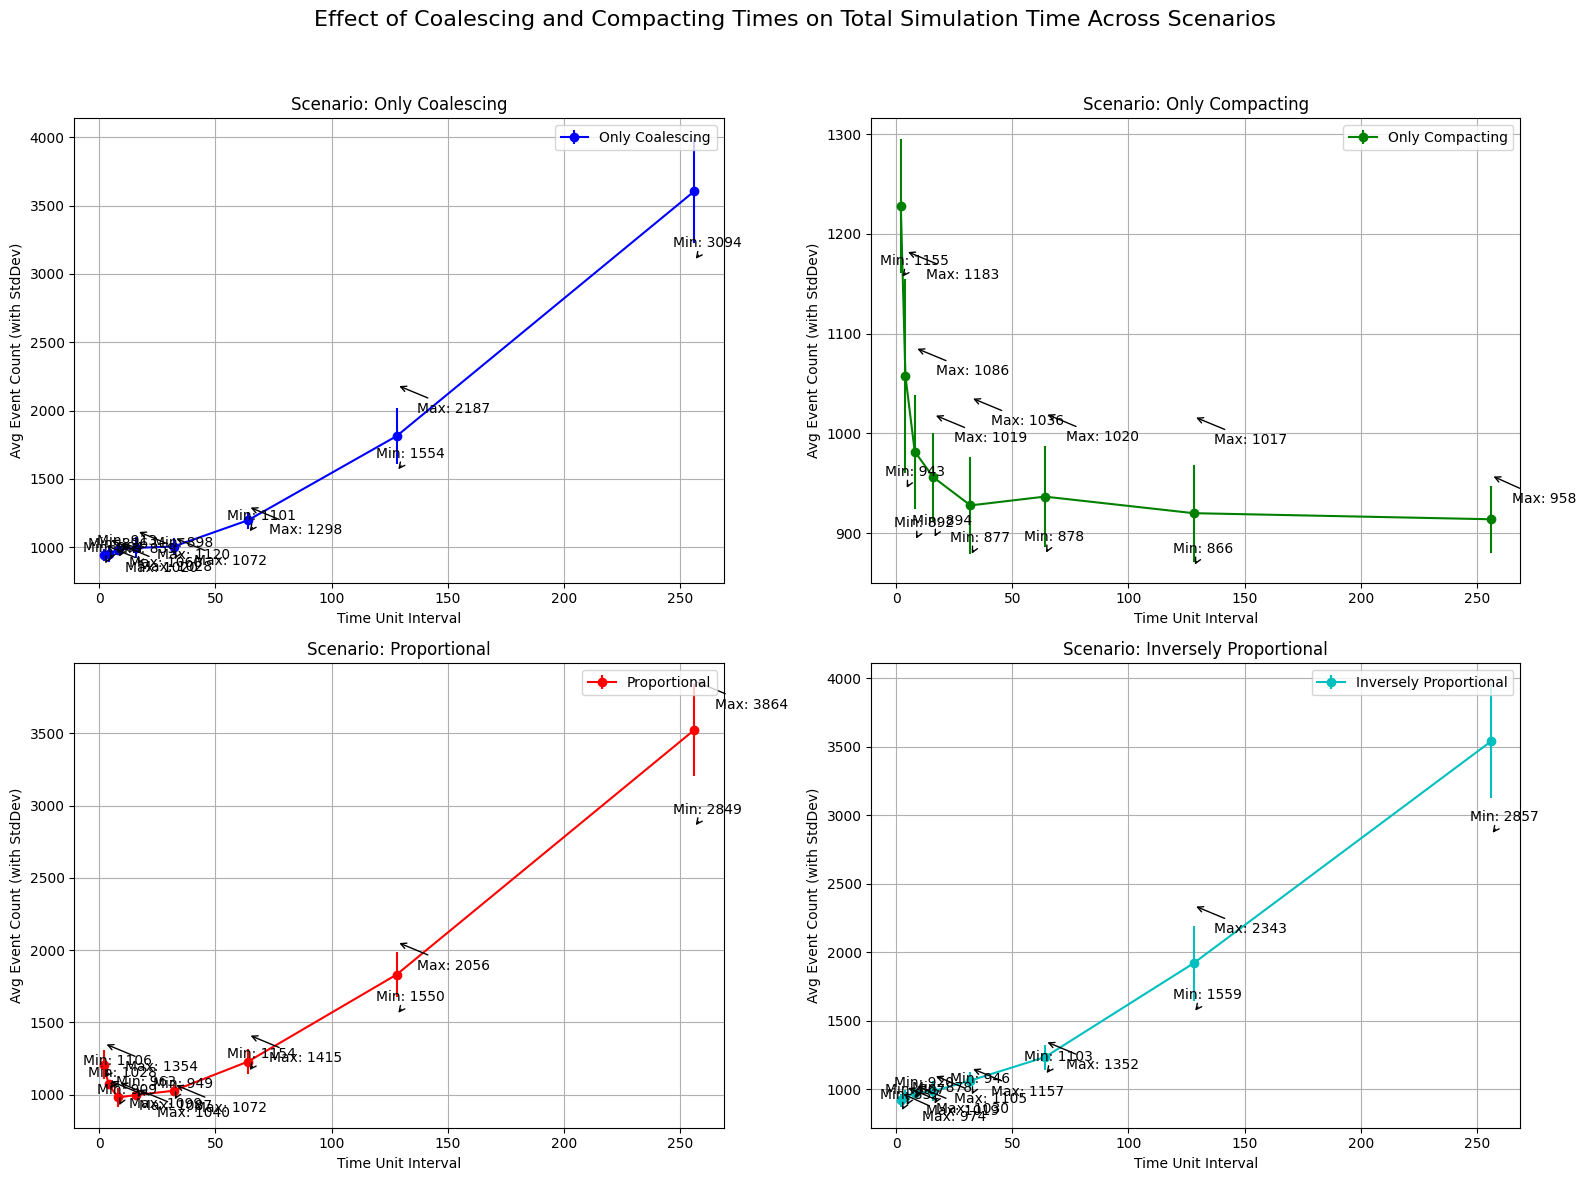

In [ ]:
#@title Effects of coalescing and compaction times on total simulation time
import random
import matplotlib.pyplot as plt
from statistics import mean, stdev

NUM_PROCESSES = 100
MEMORY_SIZE = 1000
DURATION_RANGE = (1, 15)
PROCESS_SIZE_RANGE = (100, 1000)
TIME_INTERVALS = [2**i for i in range(1, 9)]  # 2, 4, 8, 16, 32, 64, 128, 256
SCENARIOS = [
    "Only Coalescing",
    "Only Compacting",
    "Proportional",
    "Inversely Proportional"
]
BASE_CASE = (1, 20)

def generate_random_processes(num_processes):
    return [Process(str(i + 1), random.randint(*PROCESS_SIZE_RANGE), random.randint(*DURATION_RANGE)) for i in range(num_processes)]

def run_simulation_scenarios():
    results = { "avg": {}, "stdev": {}, "min": {}, "max": {} }

    for scenario in SCENARIOS:
        results["avg"][scenario] = []
        results["stdev"][scenario] = []
        results["min"][scenario] = []
        results["max"][scenario] = []

        for interval in TIME_INTERVALS:
            coalescing_time = interval if scenario != "Only Compacting" else BASE_CASE[0]
            compacting_time = interval if scenario != "Only Coalescing" else BASE_CASE[1]

            if scenario == "Inversely Proportional":
                compacting_time = TIME_INTERVALS[len(TIME_INTERVALS) - 1 - TIME_INTERVALS.index(interval)]

            test_times = []

            for _ in range(10):
                processes = generate_random_processes(NUM_PROCESSES)
                test_times.append(run_simulation(processes, coalescing_time, compacting_time))

            avg_time = mean(test_times)
            stddev_time = stdev(test_times)
            min_time = min(test_times)
            max_time = max(test_times)

            results["avg"][scenario].append((interval, avg_time))
            results["stdev"][scenario].append((interval, stddev_time))
            results["min"][scenario].append((interval, min_time))
            results["max"][scenario].append((interval, max_time))

    return results

def run_simulation(processes, coalescing_time, compacting_time):
    event_counter = [0]

    processor = Processor(
        processes,
        MEMORY_SIZE,
        coalescing_time,
        compacting_time,
        event_listener=lambda event: event_counter.append(event_counter[-1] + 1),
        show_plot=False
    )
    processor.run()
    return event_counter[-1]

def visualize_results(results):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Effect of Coalescing and Compacting Times on Total Simulation Time Across Scenarios', fontsize=16)
    colors = ['b', 'g', 'r', 'c']

    for idx, scenario in enumerate(SCENARIOS):
        row, col = idx // 2, idx % 2
        ax = axes[row, col]
        intensity = [x[0] for x in results["avg"][scenario]]
        avg_events = [x[1] for x in results["avg"][scenario]]
        stddev = [x[1] for x in results["stdev"][scenario]]

        ax.errorbar(intensity, avg_events, yerr=stddev, fmt='-o', color=colors[idx], label=f"{scenario}")

        for i, interval in enumerate(intensity):
            ax.annotate(f'Min: {results["min"][scenario][i][1]}',
                        xy=(interval, results["min"][scenario][i][1]),
                        xytext=(-15, 10), textcoords='offset points', arrowprops=dict(facecolor='green', arrowstyle="->"))
            ax.annotate(f'Max: {results["max"][scenario][i][1]}',
                        xy=(interval, results["max"][scenario][i][1]),
                        xytext=(15, -20), textcoords='offset points', arrowprops=dict(facecolor='red', arrowstyle="->"))

        ax.set_xlabel("Time Unit Interval")
        ax.set_ylabel("Avg Event Count (with StdDev)")
        ax.set_title(f"Scenario: {scenario}", fontsize=12)
        ax.grid(True)
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

results = run_simulation_scenarios()
visualize_results(results)

